
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (*ang. bias*) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorować trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda LASSO). 

Regresja grzbietowa i LASSO (Least Absolute Shrinkage and Selection Operator) to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzbietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do:

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [1]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

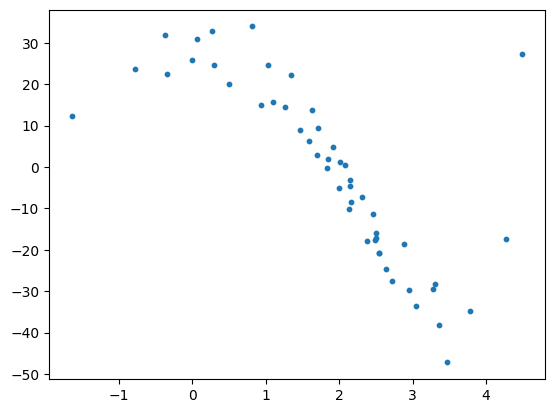

In [3]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_m x^m,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu $J(\omega)$ miała postać:

$$J_{ridge}(\omega)=\sum_{i=0}^{n-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [4]:
def regresja_L2(X, y, lamb, stopien_wielomianu):
    X = np.asarray(X).reshape(-1)
    y = np.asarray(y).reshape(-1)
    n = X.shape[0]
    m = int(stopien_wielomianu)

    # macierz projektowa (kolumna jedynek + kolejne potęgi x)
    Phi = np.ones((n, m + 1), dtype=float)
    for k in range(1, m + 1):
        Phi[:, k] = X ** k

    # normalne równanie z karą L2; nie karzemy wyrazu wolnego
    A = Phi.T @ Phi
    reg = lamb * np.eye(m + 1, dtype=float)
    reg[0, 0] = 0.0
    A_reg = A + reg
    b = Phi.T @ y

    # rozwiąż układ liniowy A_reg * w = b
    w = np.linalg.solve(A_reg, b)
    return w

Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

Współczynniki w: [27.45177824 -1.38097857 -4.32320382 -0.52553586 -0.72275373  0.23378581]


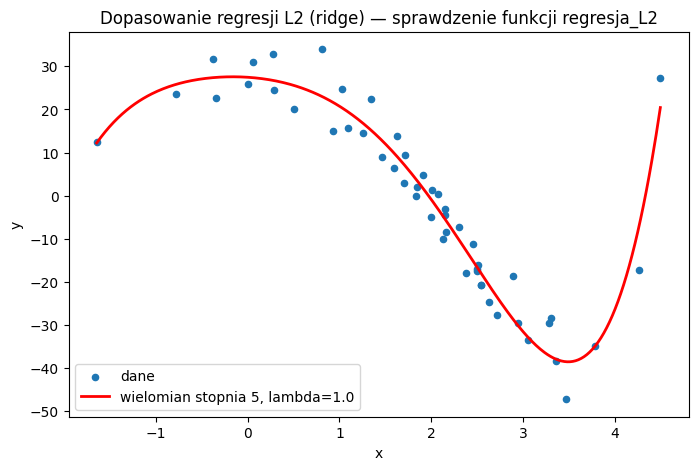

In [6]:
degree = 5
lamb = 1.0

w = regresja_L2(x, y, lamb, degree)
print("Współczynniki w:", w)

# Gęsta siatka x do rysowania gładkiej krzywej
x_plot = np.linspace(x.min(), x.max(), 400)
Phi_plot = np.ones((x_plot.size, degree + 1), dtype=float)
for k in range(1, degree + 1):
    Phi_plot[:, k] = x_plot ** k
y_plot = Phi_plot @ w

plt.figure(figsize=(8,5))
plt.scatter(x, y, s=20, label='dane')
plt.plot(x_plot, y_plot, c='red', lw=2, label=f'wielomian stopnia {degree}, lambda={lamb}')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dopasowanie regresji L2 (ridge) — sprawdzenie funkcji regresja_L2')
plt.show()

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku należy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

Wagi z regresja_L2: [27.45177824 -1.38097857 -4.32320382 -0.52553586 -0.72275373  0.23378581]
Wagi z sklearn.Ridge: [27.45177824 -1.38097857 -4.32320382 -0.52553586 -0.72275373  0.23378581]
Max abs difference: 5.688116644364527e-12
RMSE custom: 4.7708, RMSE sklearn: 4.7708


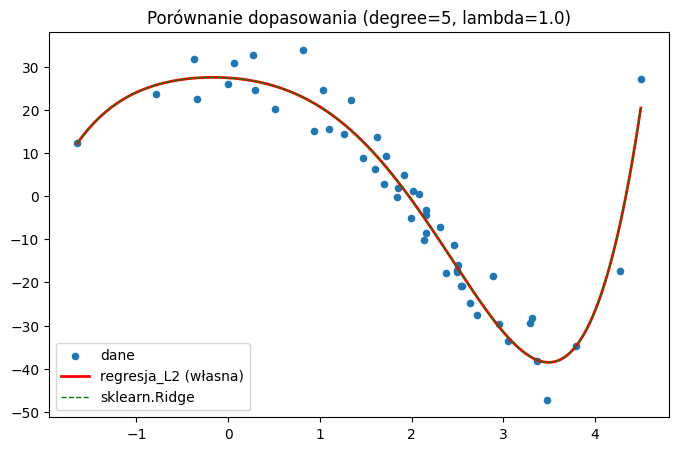

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

# zakładam, że zmienne `x`, `y`, `degree`, `lamb` oraz funkcja regresja_L2 są dostępne
X = np.asarray(x).reshape(-1)
y_arr = np.asarray(y).reshape(-1)
n = X.shape[0]
m = int(degree)

# zbuduj macierz projektową (tak jak w regresja_L2)
Phi = np.ones((n, m + 1), dtype=float)
for k in range(1, m + 1):
    Phi[:, k] = X ** k

# Twoje rozwiązanie (jeśli już jest obliczone, nadpisanie nie szkodzi)
w_custom = regresja_L2(X, y_arr, lamb, degree)

# Dla sklearn: nie przekazujemy kolumny z jedynkami -> fit_intercept=True aby intercept nie był regularizowany
Phi_no_intercept = Phi[:, 1:]
ridge = Ridge(alpha=lamb, fit_intercept=True)
ridge.fit(Phi_no_intercept, y_arr)

# złożenie wag w analogiczny format [intercept, coef...]
w_sklearn = np.concatenate(([ridge.intercept_], ridge.coef_))

print("Wagi z regresja_L2:", w_custom)
print("Wagi z sklearn.Ridge:", w_sklearn)
print("Max abs difference:", np.max(np.abs(w_custom - w_sklearn)))

# porównawcze RMSE na całym zbiorze
pred_custom = Phi @ w_custom
pred_sklearn = Phi @ w_sklearn
rmse_custom = sqrt(mean_squared_error(y_arr, pred_custom))
rmse_sklearn = sqrt(mean_squared_error(y_arr, pred_sklearn))
print(f"RMSE custom: {rmse_custom:.4f}, RMSE sklearn: {rmse_sklearn:.4f}")

# wykres porównawczy
x_plot = np.linspace(X.min(), X.max(), 400)
Phi_plot = np.ones((x_plot.size, m + 1), dtype=float)
for k in range(1, m + 1):
    Phi_plot[:, k] = x_plot ** k
y_plot_custom = Phi_plot @ w_custom
y_plot_sklearn = Phi_plot @ w_sklearn

plt.figure(figsize=(8,5))
plt.scatter(X, y_arr, s=20, label='dane')
plt.plot(x_plot, y_plot_custom, c='red', lw=2, label='regresja_L2 (własna)')
plt.plot(x_plot, y_plot_sklearn, c='green', lw=1, linestyle='--', label='sklearn.Ridge')
plt.legend()
plt.title(f'Porównanie dopasowania (degree={degree}, lambda={lamb})')
plt.show()


Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostać podzielony na zbiór uczący i testowy.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, test_size=0.2, random_state=42)

Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [ ]:
# Miejsce na potrzebne funkcje
def plot_ridge_cv_vs_lambda(X_train, y_train, degree=15, lambdas=None, cv=5, random_state=42):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error

    X = np.asarray(X_train).reshape(-1)
    y = np.asarray(y_train).reshape(-1)
    n = X.shape[0]

    # domyślna lista lambda
    if lambdas is None:
        lambdas = [0.0]
        v = 0.01
        while v <= 10.0 + 1e-12:
            lambdas.append(round(v, 12))
            v *= 2.0

    # przygotuj macierz projektową Phi (kolumna jedynek + kolejne potęgi x)
    m = int(degree)
    def design_matrix(x):
        Phi = np.ones((x.size, m + 1), dtype=float)
        for k in range(1, m + 1):
            Phi[:, k] = x ** k
        return Phi

    Phi_all = design_matrix(X)

    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    mean_train_rmse = []
    mean_val_rmse = []
    coeffs_full = []  # współczynniki wyuczone na całym zbiorze treningowym dla każdej lambda

    for lam in lambdas:
        train_mses = []
        val_mses = []

        # CV manualne: w każdej iteracji rozwiązujemy normalne równanie z reg. L2,
        # bez regularizacji wyrazu wolnego (reg[0,0]=0)
        for train_idx, val_idx in kf.split(Phi_all):
            Phi_tr = Phi_all[train_idx]
            y_tr = y[train_idx]
            Phi_val = Phi_all[val_idx]
            y_val = y[val_idx]

            A = Phi_tr.T @ Phi_tr
            reg = lam * np.eye(m + 1, dtype=float)
            reg[0, 0] = 0.0  # nie regularizujemy wyrazu wolnego
            A_reg = A + reg
            b = Phi_tr.T @ y_tr
            w = np.linalg.solve(A_reg, b)

            pred_tr = Phi_tr @ w
            pred_val = Phi_val @ w
            train_mses.append(mean_squared_error(y_tr, pred_tr))
            val_mses.append(mean_squared_error(y_val, pred_val))

        mean_train_rmse.append(np.sqrt(np.mean(train_mses)))
        mean_val_rmse.append(np.sqrt(np.mean(val_mses)))

        # współczynniki wyuczone na całym zbiorze treningowym dla tej lambda
        A_all = Phi_all.T @ Phi_all
        reg_all = lam * np.eye(m + 1, dtype=float)
        reg_all[0, 0] = 0.0
        w_all = np.linalg.solve(A_all + reg_all, Phi_all.T @ y)
        coeffs_full.append(w_all)

    coeffs_full = np.array(coeffs_full)  # shape (len(lambdas), m+1)

    # Rysunki
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    # dla osi x użyjemy skali log dla lambda>0; zastąp 0 małą wartością aby log działał
    lambdas_plot = np.array(lambdas, dtype=float)
    lambdas_plot_for_log = lambdas_plot.copy()
    eps = 1e-6
    lambdas_plot_for_log[lambdas_plot_for_log == 0] = eps
    plt.semilogx(lambdas_plot_for_log, mean_train_rmse, marker='o', label='RMSE uczenia')
    plt.semilogx(lambdas_plot_for_log, mean_val_rmse, marker='s', label='RMSE walidacji')
    # oznacz wartość 0 specjalnie na osi
    if 0.0 in lambdas_plot:
        i0 = list(lambdas).index(0.0)
        plt.scatter(eps, mean_train_rmse[i0], color='C0')
        plt.scatter(eps, mean_val_rmse[i0], color='C1')
        plt.text(eps, max(mean_train_rmse[i0], mean_val_rmse[i0]), '  λ=0', verticalalignment='bottom', fontsize=8)
    plt.xlabel('λ (skala log)')
    plt.ylabel('RMSE')
    plt.title(f'CV (k={cv}) — RMSE vs λ (degree={degree})')
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.4)

    # Wykres współczynników: rysujemy wartości współczynników (omega_0..omega_m) w funkcji lambda
    plt.subplot(1, 2, 2)
    for j in range(m + 1):
        plt.semilogx(lambdas_plot_for_log, coeffs_full[:, j], marker='.', label=f'ω_{j}' if j<=5 else None, alpha=0.8)
    plt.xlabel('λ (skala log)')
    plt.ylabel('Wartość współczynnika ω_j')
    plt.title('Współczynniki vs λ')
    # pokaż legendę tylko dla kilku pierwszych by nie zaśmiecać (można odkomentować pełną legendę)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return {
        'lambdas': lambdas,
        'mean_train_rmse': np.array(mean_train_rmse),
        'mean_val_rmse': np.array(mean_val_rmse),
        'coeffs_full': coeffs_full
    }

**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

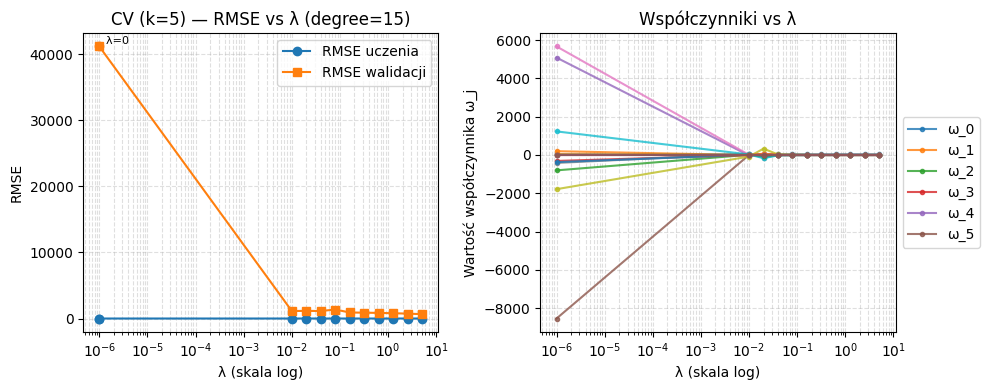

Lambda		RMSE_train	RMSE_val	||w_rest||_2
     0	  3.2394	41167.9154	11700.0936
  0.01	  3.5060	1140.4902	113.3026
  0.02	  3.5377	1158.7003	425.9828
  0.04	  3.5846	1140.0368	 40.1320
  0.08	  3.5832	1362.5417	 17.9963
  0.16	  3.5949	915.0617	 10.2344
  0.32	  3.6171	886.8679	  7.2369
  0.64	  3.6405	851.0824	  5.7564
  1.28	  3.6702	805.3165	  4.6694
  2.56	  3.7138	742.3216	  3.5690
  5.12	  3.7727	660.1685	  2.5780


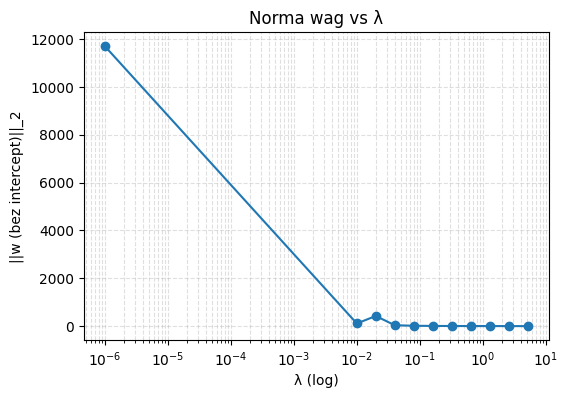


Najlepsza lambda (min RMSE walidacji): 5.12  -> RMSE_val = 660.1685, RMSE_train = 3.7727

Najważniejsze współczynniki (bez intercept) dla najlepszej lambda:
 1. ω_1 = -1.478844   |ω| = 1.478844
 2. ω_3 = -1.229288   |ω| = 1.229288
 3. ω_2 = -1.083254   |ω| = 1.083254
 4. ω_4 = -0.919141   |ω| = 0.919141
 5. ω_9 = -0.593253   |ω| = 0.593253
 6. ω_5 = -0.557774   |ω| = 0.557774
 7. ω_8 =  0.320564   |ω| = 0.320564
 8. ω_7 =  0.306025   |ω| = 0.306025
 9. ω_10 =  0.173761   |ω| = 0.173761
10. ω_11 =  0.135241   |ω| = 0.135241

RMSE (wytrenowany na całym X_train) dla λ=5.12: train=4.0709, test=5.3663


In [12]:
# ustawienia
degree = 15

# zbuduj listę lambda zgodnie z przykładem (0, 0.01, 0.02, 0.04, ... do 10)
lambdas = [0.0]
v = 0.01
while v <= 10.0 + 1e-12:
    lambdas.append(round(v, 12))
    v *= 2.0

# wywołaj funkcję, która rysuje wykresy i zwraca wyniki (jeśli masz już zdefiniowaną plot_ridge_cv_vs_lambda)
res = plot_ridge_cv_vs_lambda(X_train, y_train, degree=degree, lambdas=lambdas, cv=5, random_state=42)

lams = np.array(res['lambdas'], dtype=float)
train_rmse = res['mean_train_rmse']
val_rmse = res['mean_val_rmse']
coeffs = res['coeffs_full']  # shape (len(lambdas), degree+1)

# 1) Jak zmieniają się wartości współczynników?
# oblicz norma L2 wag bez wyrazu wolnego dla każdej lambda
coef_norms = np.linalg.norm(coeffs[:, 1:], axis=1)

print("Lambda\t\tRMSE_train\tRMSE_val\t||w_rest||_2")
for L, tr, va, cn in zip(lams, train_rmse, val_rmse, coef_norms):
    print(f"{L:>6.4g}\t{tr:8.4f}\t{va:8.4f}\t{cn:8.4f}")

# dodatkowy wykres normy wag vs lambda (skala log; 0 zastąpiona małą wartością)
plt.figure(figsize=(6,4))
lplot = lams.copy()
lplot_for_log = lplot.copy()
eps = 1e-6
lplot_for_log[lplot_for_log == 0] = eps
plt.semilogx(lplot_for_log, coef_norms, marker='o')
plt.xlabel("λ (log)")
plt.ylabel("||w (bez intercept)||_2")
plt.title("Norma wag vs λ")
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# 2) Która lambda jest najlepsza (minimalizuje średni błąd walidacji)?
best_idx = np.argmin(val_rmse)
best_lambda = lams[best_idx]
print(f"\nNajlepsza lambda (min RMSE walidacji): {best_lambda}  -> RMSE_val = {val_rmse[best_idx]:.4f}, RMSE_train = {train_rmse[best_idx]:.4f}")

# pokaż najistotniejsze współczynniki dla najlepszej lambda (posortowane wg |wartość|)
w_best = coeffs[best_idx]
abs_sorted_idx = np.argsort(-np.abs(w_best[1:]))  # bez intercept
print("\nNajważniejsze współczynniki (bez intercept) dla najlepszej lambda:")
for rank, idx in enumerate(abs_sorted_idx[:10], start=1):
    print(f"{rank:2d}. ω_{idx+1} = {w_best[idx+1]: .6f}   |ω| = {abs(w_best[idx+1]):.6f}")

# (opcjonalnie) oblicz RMSE na zbiorze testowym dla modelu wyuczonego na całym X_train przy best_lambda
# przygotuj macierz projektową
def design_matrix(x, deg):
    x = np.asarray(x).reshape(-1)
    Phi = np.ones((x.size, deg+1), dtype=float)
    for k in range(1, deg+1):
        Phi[:, k] = x ** k
    return Phi

Phi_train = design_matrix(X_train, degree)
Phi_test = design_matrix(X_test, degree)
# wylicz w dla best_lambda (bez karania intercept)
A_all = Phi_train.T @ Phi_train
reg_all = best_lambda * np.eye(degree+1, dtype=float)
reg_all[0,0] = 0.0
w_final = np.linalg.solve(A_all + reg_all, Phi_train.T @ y_train)

rmse_train_final = sqrt(mean_squared_error(y_train, Phi_train @ w_final))
rmse_test_final = sqrt(mean_squared_error(y_test, Phi_test @ w_final))
print(f"\nRMSE (wytrenowany na całym X_train) dla λ={best_lambda}: train={rmse_train_final:.4f}, test={rmse_test_final:.4f}")

**Odpowiedzi**
1.Przy większym współczynniku lambda znacznie maleje błąd walidacji, nie widać jednak dużych różnić w błędzie uczenia. Wartości współczynników wraz ze wzrostem lambda zbiegają do zera.
2. Najlepszy w testownym wypadku jest współczynnik lambda ~ 5.12.

Wytrenuj model (stopnia 15) dla wybranego współczynnika λ (uczenie na całym zbiorze treningowym).

Oblicz RMSE = $ \sqrt{\frac{1}{n}\sum_{i=1}^{n}\big(\hat f(x_i)-y_i\big)^2 } $ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.

In [13]:
if 'best_lambda' in globals():
    lam = float(best_lambda)
elif 'res' in globals() and 'lambdas' in res:
    lam = float(res['lambdas'][np.argmin(res['mean_val_rmse'])])
else:
    lam = 0.01  # domyślna fallback wartość

def design_matrix(x, degree):
    x = np.asarray(x).reshape(-1)
    Phi = np.ones((x.size, degree + 1), dtype=float)
    for k in range(1, degree + 1):
        Phi[:, k] = x ** k
    return Phi

def fit_ridge_no_intercept_reg(Phi, y, lam):
    # Phi zawiera kolumnę jedynek (intercept w kolumnie 0) -> nie regularizujemy wyrazu wolnego
    m = Phi.shape[1]
    A = Phi.T @ Phi
    reg = lam * np.eye(m, dtype=float)
    reg[0, 0] = 0.0
    w = np.linalg.solve(A + reg, Phi.T @ y)
    return w

# train/test dane: X_train, X_test, y_train, y_test powinny być zdefiniowane wcześniej
degree15 = 15
degree5 = 5

Phi_train_15 = design_matrix(X_train, degree15)
Phi_test_15  = design_matrix(X_test, degree15)

w15 = fit_ridge_no_intercept_reg(Phi_train_15, y_train, lam)
rmse_train_15 = sqrt(mean_squared_error(y_train, Phi_train_15 @ w15))
rmse_test_15  = sqrt(mean_squared_error(y_test,  Phi_test_15  @ w15))

Phi_train_5 = design_matrix(X_train, degree5)
Phi_test_5  = design_matrix(X_test, degree5)

w5 = fit_ridge_no_intercept_reg(Phi_train_5, y_train, lam)
rmse_train_5 = sqrt(mean_squared_error(y_train, Phi_train_5 @ w5))
rmse_test_5  = sqrt(mean_squared_error(y_test,  Phi_test_5  @ w5))

print(f"Użyte λ = {lam}")
print(f"Stopień 15: RMSE_train = {rmse_train_15:.4f}, RMSE_test = {rmse_test_15:.4f}")
print(f"Stopień  5: RMSE_train = {rmse_train_5:.4f}, RMSE_test = {rmse_test_5:.4f}")

# (opcjonalnie) porównanie różnicy błędów
print(f"Różnica (test): RMSE_test(15) - RMSE_test(5) = {rmse_test_15 - rmse_test_5:.4f}")


Użyte λ = 5.12
Stopień 15: RMSE_train = 4.0709, RMSE_test = 5.3663
Stopień  5: RMSE_train = 4.7231, RMSE_test = 5.2283
Różnica (test): RMSE_test(15) - RMSE_test(5) = 0.1379


### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [15]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('MED_Lab_dane/kc_house_data.csv', dtype=dtype_dict)

In [16]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [17]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
from sklearn.model_selection import train_test_split

# sales - DataFrame już załadowany wcześniej
sales_train, sales_test = train_test_split(sales, test_size=0.2, random_state=42)

# reset indeksów (wygodne do późniejszej pracy)
sales_train = sales_train.reset_index(drop=True)
sales_test  = sales_test.reset_index(drop=True)

# podstawowe y dla dalszych zadań
y_train = sales_train['price']
y_test  = sales_test['price']

# jeśli chcesz od razu przygotować X_train/X_test dla listy `features`
# (upewnij się, że `features` jest zdefiniowana w dalszej części notatnika)
if 'features' in globals():
    X_train = sales_train[features]
    X_test  = sales_test[features]

Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [ ]:
from sklearn.dummy import DummyRegressor
import itertools
lr = LinearRegression()
features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living',
            'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors',
            'floors_square', 'waterfront', 'view', 'condition', 'grade',
            'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

y = sales['price'].values

# baseline: intercept-only (predict mean) using DummyRegressor
X_dummy = np.zeros((len(sales), 1))
dummy = DummyRegressor(strategy='mean')
scores = cross_val_score(dummy, X_dummy, y, scoring='neg_mean_squared_error', cv=5)
rmse_baseline = sqrt(-scores.mean())
print(f"Intercept-only (baseline) CV RMSE = {rmse_baseline:.4f}\n")

# dla każdego k wybierz najlepszy zestaw cech (minimalne CV RMSE)
best_sets = {}
for k in range(1, len(features) + 1):
    best_rmse = np.inf
    best_combo = None
    # iteracja po wszystkich kombinacjach rozmiaru k
    for combo in itertools.combinations(features, k):
        X_combo = sales[list(combo)]
        scores = cross_val_score(lr, X_combo, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        rmse = sqrt(-scores.mean())
        if rmse < best_rmse:
            best_rmse = rmse
            best_combo = combo
    best_sets[k] = (best_combo, best_rmse)
    print(f"k={k:2d}  best RMSE = {best_rmse:.4f}  best features = {list(best_combo)}")

# (opcjonalnie) wypisz porównanie kilku najlepszych rozmiarów
print("\nPodsumowanie (najlepsze zestawy dla każdego k):")

for k, (combo, rmse) in best_sets.items():
    print(f" {k:2d} features -> RMSE = {rmse:.4f}  |  features: {list(combo)}")

Intercept-only (baseline) CV RMSE = 367280.9710

k= 1  best RMSE = 261590.1060  best features = ['sqft_living']
k= 2  best RMSE = 250417.7208  best features = ['sqft_living', 'view']
k= 3  best RMSE = 232256.4057  best features = ['sqft_living', 'grade', 'yr_built']
k= 4  best RMSE = 222015.2145  best features = ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']
k= 5  best RMSE = 213689.6609  best features = ['sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built']
k= 6  best RMSE = 211469.1870  best features = ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built']
k= 7  best RMSE = 209629.0511  best features = ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'waterfront', 'view', 'grade', 'yr_built']
k= 8  best RMSE = 208622.9200  best features = ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot_sqrt', 'waterfront', 'view', 'grade', 'yr_built']


c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


k= 9  best RMSE = 208101.1336  best features = ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'waterfront', 'view', 'grade', 'yr_built']
k=10  best RMSE = 207600.8027  best features = ['bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
k=11  best RMSE = 207313.0096  best features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
k=12  best RMSE = 207132.8820  best features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
k=13  best RMSE = 206926.0065  best features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'yr_built']
k=14  best RMSE = 206817.980

Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [22]:
# Miejce na kod
def forward_selection_greedy(df_train, target_col, candidate_features, model, cv=5, n_jobs=-1):
    selected = []
    remaining = candidate_features.copy()
    best_rmse_per_step = []
    best_combo_per_step = []

    y = df_train[target_col].values

    # baseline: intercept-only (brak cech)
    X_dummy = np.zeros((len(df_train), 1))
    scores = cross_val_score(model, X_dummy, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)
    baseline_rmse = sqrt(-scores.mean())
    print(f"Baseline (intercept-only) CV RMSE = {baseline_rmse:.4f}\n")

    for k in range(1, len(candidate_features) + 1):
        best_rmse = np.inf
        best_feat = None

        for feat in remaining:
            trial_feats = selected + [feat]
            X_trial = df_train[trial_feats]
            scores = cross_val_score(model, X_trial, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=n_jobs)
            rmse = sqrt(-scores.mean())
            if rmse < best_rmse:
                best_rmse = rmse
                best_feat = feat

        if best_feat is None:
            break

        selected.append(best_feat)
        remaining.remove(best_feat)
        best_rmse_per_step.append(best_rmse)
        best_combo_per_step.append(selected.copy())

        print(f"Step {k:02d}: added '{best_feat}' -> CV RMSE = {best_rmse:.4f}")

    return {
        'selected_order': selected,
        'rmse_per_step': best_rmse_per_step,
        'combo_per_step': best_combo_per_step,
        'baseline_rmse': baseline_rmse
    }

# Wywołanie (używa sales_train i y_train z wcześniej wykonanego podziału)
lr = LinearRegression()
features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living',
            'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors',
            'floors_square', 'waterfront', 'view', 'condition', 'grade',
            'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

res_greedy = forward_selection_greedy(sales_train, 'price', features, lr, cv=5, n_jobs=-1)

print("\nPodsumowanie wyboru zachłannego:")
for i, (combo, rmse) in enumerate(zip(res_greedy['combo_per_step'], res_greedy['rmse_per_step']), start=1):
    print(f" k={i:2d} features -> RMSE = {rmse:.4f}  |  features: {combo}")

Baseline (intercept-only) CV RMSE = 361462.0319

Step 01: added 'sqft_living' -> CV RMSE = 257756.7751
Step 02: added 'sqft_living_sqrt' -> CV RMSE = 245601.2259
Step 03: added 'grade' -> CV RMSE = 232774.0561
Step 04: added 'yr_built' -> CV RMSE = 216707.9470
Step 05: added 'waterfront' -> CV RMSE = 209081.0519
Step 06: added 'bathrooms' -> CV RMSE = 206602.6793
Step 07: added 'view' -> CV RMSE = 204493.9464
Step 08: added 'sqft_lot_sqrt' -> CV RMSE = 203657.7249
Step 09: added 'condition' -> CV RMSE = 203291.3884
Step 10: added 'floors_square' -> CV RMSE = 202922.2802
Step 11: added 'sqft_lot' -> CV RMSE = 202702.8594
Step 12: added 'floors' -> CV RMSE = 202549.2091
Step 13: added 'bedrooms' -> CV RMSE = 202408.7044
Step 14: added 'yr_renovated' -> CV RMSE = 202318.1940
Step 15: added 'sqft_basement' -> CV RMSE = 202364.2472
Step 16: added 'sqft_above' -> CV RMSE = 202364.2472
Step 17: added 'bedrooms_square' -> CV RMSE = 207025.2504

Podsumowanie wyboru zachłannego:
 k= 1 features -

**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**

# Podobieństwa
    1. W obydwu wypadkach wyniki spadają po dodaniu bedroom_square, przez wartości tego parametru utrudnia on uczenie.
# Różnice
    1. Pierwszy inny wybór przy k=2, ten algorytmu zachłannego jest lepszy.
    2. Bardzo duża różnica w czasie wykonywania, zachłanny około 360000 razy szybszy.
# Wnioski
    1. Zachłanny lepsze wybór przy k=2, osiąga mniejsze RMSE.
    2. Zachłanny lepszy też przy k>=9.
    4. Zachłanny w całkowitym czasie wykonywania, jak i wynikach jest znacząco lepszą opcją.

### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [30]:
# Zmieniony kod bo nie doszło do zbieżności
from sklearn import linear_model  # using scikit-learn
from sklearn.preprocessing import StandardScaler

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sales[all_features])
y = sales['price'].values

# Fit Lasso with fixed alpha
lasso = linear_model.Lasso(alpha=5e2, max_iter=200000)
lasso.fit(X_scaled, y)
coef = lasso.coef_

# Fit LassoCV to find best alpha automatically
lcv = linear_model.LassoCV(cv=5, max_iter=200000, n_jobs=-1, random_state=42)
lcv.fit(X_scaled, y)
coef_cv = lcv.coef_

#display results
df_coef = pd.DataFrame({
    'feature': all_features,
    'coef_lasso': coef,
    'coef_lasso_cv': coef_cv
})
df_coef['abs_lasso_cv'] = df_coef['coef_lasso_cv'].abs()
df_coef['selected_lasso'] = df_coef['coef_lasso'].abs() > 1e-8
df_coef['selected_lasso_cv'] = df_coef['coef_lasso_cv'].abs() > 1e-8
df_coef = df_coef.sort_values('abs_lasso_cv', ascending=False).reset_index(drop=True)

print("\nTabela współczynników (posortowane wg |coef LassoCV|):")
print(df_coef.to_string(index=False))

# dodatkowe statystyki
print(f"\nLasso (alpha=500) intercept: {lasso.intercept_:.4e}, n_nonzero: {df_coef['selected_lasso'].sum()}")
print(f"LassoCV best alpha: {lcv.alpha_:.4g}, intercept: {lcv.intercept_:.4e}, n_nonzero: {df_coef['selected_lasso_cv'].sum()}")

# ocena modelu LassoCV na całym X_scaled (5-fold CV RMSE)
best_lasso = linear_model.Lasso(alpha=lcv.alpha_, max_iter=20000)
scores = cross_val_score(best_lasso, X_scaled, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
rmse_cv = sqrt(-scores.mean())
print(f"\nLassoCV (alpha={lcv.alpha_:.4g}) 5-fold CV RMSE = {rmse_cv:.4f}")

# wypisz tylko wybrane cechy (LassoCV) w kolejności malejącej ważności
print("\nWybrane cechy przez LassoCV (wg |współczynnik|):")
for i, row in df_coef[df_coef['selected_lasso_cv']].iterrows():
    print(f"  {row['feature']:<18} coef = {row['coef_lasso_cv']:.6e}")


Tabela współczynników (posortowane wg |coef LassoCV|):
         feature     coef_lasso  coef_lasso_cv  abs_lasso_cv  selected_lasso  selected_lasso_cv
     sqft_living  517349.649655  490274.862791 490274.862791            True               True
sqft_living_sqrt -380027.658894 -353198.866053 353198.866053            True               True
           grade  152615.900821  151970.971403 151970.971403            True               True
        yr_built  -93795.843357  -93620.444252  93620.444252            True               True
      waterfront   48570.935115   48376.248113  48376.248113            True               True
   sqft_lot_sqrt  -40933.604820  -36933.235779  36933.235779            True               True
       bathrooms   37745.389305   36358.191018  36358.191018            True               True
            view   31684.135392   32052.920280  32052.920280            True               True
        sqft_lot   23318.593778   19736.398662  19736.398662            True    

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

Algorytm wybrał wszystkie cechy inne niż floors i sqft_above.

Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

LassoCV best alpha (train): 890.6
RMSE train/test dla alpha=890.6: 202104.5449 / 222270.5817


c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e+13, tolerance: 1.847e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e+13, tolerance: 1.841e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\szepiet33\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, c

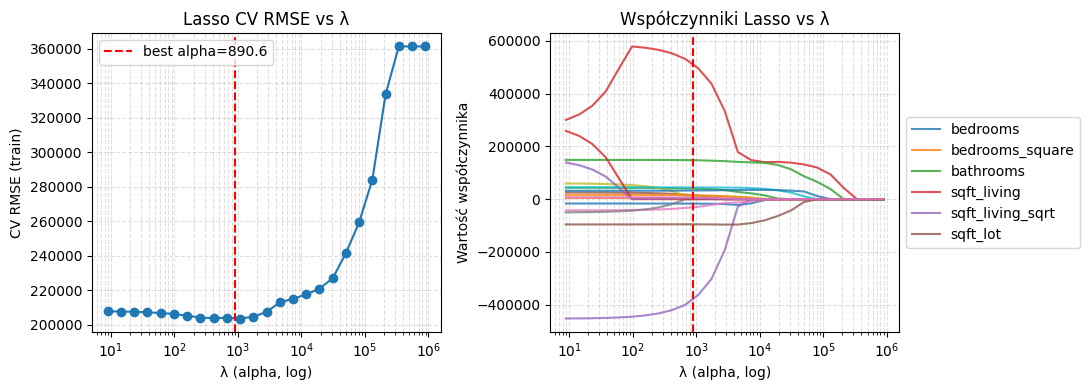


Cechy (niezerowe) przy alpha ~ best (posortowane wg |coef|):
         feature   coef_at_best      abs_coef
     sqft_living  496069.720619 496069.720619
sqft_living_sqrt -363164.241424 363164.241424
           grade  147362.370551 147362.370551
        yr_built  -95343.904079  95343.904079
      waterfront   44426.447914  44426.447914
       bathrooms   39599.856252  39599.856252
            view   32863.085575  32863.085575
   sqft_lot_sqrt  -28955.413267  28955.413267
        bedrooms  -16922.551856  16922.551856
       condition   14535.659577  14535.659577
        sqft_lot   13080.541833  13080.541833
   floors_square   12801.149379  12801.149379
    yr_renovated    5881.010764   5881.010764
   sqft_basement    3129.894656   3129.894656
 bedrooms_square    2841.721691   2841.721691


In [33]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

# przygotuj skalowane X_train / X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(sales_train[all_features])
X_test_scaled  = scaler.transform(sales_test[all_features])
y_train = sales_train['price'].values
y_test  = sales_test['price'].values

# 1) LassoCV na zbiorze uczącym (zmniejsz max_iter, LassoCV ma własną siatkę alpha)
lcv = LassoCV(cv=5, n_jobs=-1, max_iter=10000, random_state=42, tol=1e-3)
lcv.fit(X_train_scaled, y_train)
best_alpha = lcv.alpha_
print(f"LassoCV best alpha (train): {best_alpha:.4g}")

# ocena modelu z najlepszym alpha na train/test
best_model = Lasso(alpha=best_alpha, max_iter=10000, tol=1e-3)
best_model.fit(X_train_scaled, y_train)
rmse_train = sqrt(mean_squared_error(y_train, best_model.predict(X_train_scaled)))
rmse_test  = sqrt(mean_squared_error(y_test,  best_model.predict(X_test_scaled)))
print(f"RMSE train/test dla alpha={best_alpha:.4g}: {rmse_train:.4f} / {rmse_test:.4f}")

# 2) Zmniejsz liczbę alphas do 25 i użyj warm_start dla przyspieszenia
alphas = np.logspace(np.log10(max(best_alpha, 1e-6)) - 2, np.log10(max(best_alpha, 1e-6)) + 3, 25)
cv_rmses = []
coefs = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for a in alphas:
    fold_mses = []
    # manualna pętla CV z warm_start (szybsze niż cross_val_score)
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        model = Lasso(alpha=a, max_iter=10000, tol=1e-3, warm_start=False)
        model.fit(X_tr, y_tr)
        fold_mses.append(mean_squared_error(y_val, model.predict(X_val)))
    
    cv_rmses.append(sqrt(np.mean(fold_mses)))
    
    # fit na całym zbiorze dla współczynników
    model_full = Lasso(alpha=a, max_iter=10000, tol=1e-3)
    model_full.fit(X_train_scaled, y_train)
    coefs.append(model_full.coef_.copy())

coefs = np.array(coefs)

# 3) Wykresy
plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.semilogx(alphas, cv_rmses, marker='o')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'best alpha={best_alpha:.4g}')
plt.xlabel('λ (alpha, log)')
plt.ylabel('CV RMSE (train)')
plt.title('Lasso CV RMSE vs λ')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.4)

plt.subplot(1,2,2)
for j, feat in enumerate(all_features):
    plt.semilogx(alphas, coefs[:, j], label=feat if j < 6 else None, alpha=0.8)
plt.axvline(best_alpha, color='red', linestyle='--')
plt.xlabel('λ (alpha, log)')
plt.ylabel('Wartość współczynnika')
plt.title('Współczynniki Lasso vs λ')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

# 4) Tabela cech
idx_best = np.argmin(np.abs(alphas - best_alpha))
df_sel = pd.DataFrame({'feature': all_features, 'coef_at_best': coefs[idx_best]})
df_sel['abs_coef'] = df_sel['coef_at_best'].abs()
df_sel = df_sel.sort_values('abs_coef', ascending=False).reset_index(drop=True)
print("\nCechy (niezerowe) przy alpha ~ best (posortowane wg |coef|):")
print(df_sel[df_sel['abs_coef'] > 1e-8].to_string(index=False))

**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [ ]:
# Miejsce na kod
1. Najlepszą wartością dla parametru okazuje się 890.6.
2. 